# Image generation (plus some gold mining)

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib.pyplot as plt

from units import *
from simulation import SubhaloSimulator

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Prior

In [2]:
mass_base_unit = 1.e7 * M_s

In [3]:
alpha_mean = 2e8/M_s * mass_base_unit  * (mass_base_unit / M_s)**-1.9
alpha_std = alpha_mean * 0.1
print(alpha_mean, "+/-", alpha_std)

beta_mean = -1.9
beta_std = 0.05

100.2374467254546 +/- 10.023744672545462


## Draw parameters to generate

In [4]:
n_sims = 1000
n_theta_samples = 100

In [5]:
alpha = np.random.normal(loc=alpha_mean, scale=alpha_std, size=n_sims)
beta = np.random.normal(loc=beta_mean, scale=beta_std, size=n_sims)
parameters = np.vstack((alpha, beta)).T

assert np.min(alpha) > 0.
assert np.max(beta) < -1.

## Generate data

In [6]:
sim = SubhaloSimulator(
    mass_base_unit=mass_base_unit,
    resolution=64,
)

# images = sim.rvs(alpha, beta, n_sims)
# images, t_xz, log_r_xz, latents = sim.rvs_score_ratio(alpha, beta, alpha_mean, beta_mean, n_sims)

images, t_xz, log_r_xz, log_r_xz_uncertainties, latents = sim.rvs_score_ratio_to_evidence(
    alpha,
    beta,
    alpha_mean,
    alpha_std,
    beta_mean,
    beta_std,
    n_sims,
    n_theta_samples,
)

r_xz = np.exp(log_r_xz, dtype=np.float64)
y = np.zeros(n_sims)
n_subs = np.array([v[0] for v in latents])


Simulating image 50 / 1000
Simulating image 100 / 1000
Simulating image 150 / 1000
Simulating image 200 / 1000
Simulating image 250 / 1000
Simulating image 300 / 1000
Simulating image 350 / 1000
Simulating image 400 / 1000
Simulating image 450 / 1000
Simulating image 500 / 1000
Simulating image 550 / 1000
Simulating image 600 / 1000
Simulating image 650 / 1000
Simulating image 700 / 1000
Simulating image 750 / 1000
Simulating image 800 / 1000
Simulating image 850 / 1000
Simulating image 900 / 1000
Simulating image 950 / 1000
Simulating image 1000 / 1000


In [7]:
if not os.path.exists("../data"):
    os.mkdir("../data")

np.save("../data/theta.npy", parameters)
np.save("../data/x.npy", images)
np.save("../data/y.npy", y)
np.save("../data/t_xz.npy", t_xz)
np.save("../data/r_xz.npy", r_xz)
np.save("../data/log_r_xz.npy", log_r_xz)
np.save("../data/log_r_xz_uncertainties.npy", log_r_xz_uncertainties)

## A first look at the data

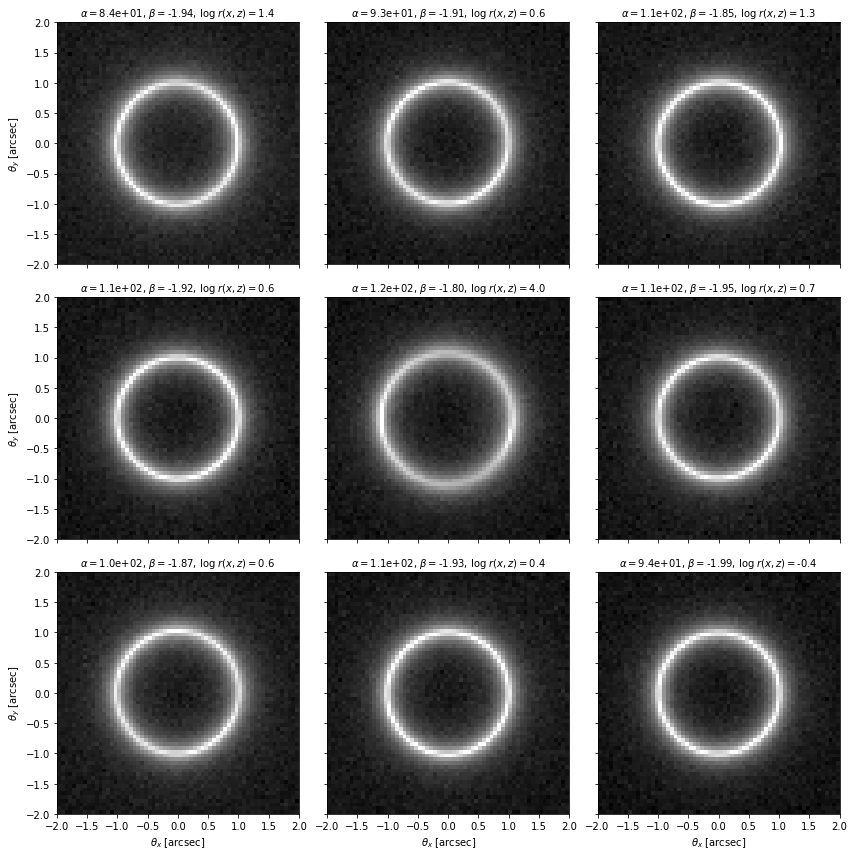

In [8]:
plt.figure(figsize=(12,12))

for i in [6,7,8,0,3,1,2,4,5]:
    if i == 6:
        ax_y = plt.subplot(3,3,i+1)
        ax_x = ax_y
    elif i in [7,8]:
        ax_x = plt.subplot(3,3,i+1, sharey=ax_y)
    elif i in [0,3]:
        ax_y = plt.subplot(3,3,i+1, sharex=ax_x)
    else:
        ax = plt.subplot(3,3,i+1, sharey=ax_y, sharex=ax_x)
        
    plt.imshow(np.log10(images[i]), vmax=3.5, cmap='gist_gray', extent=(-2.,2.,-2.,2.), origin="lower")
    description = r"$\alpha = ${:.1e}, $\beta = ${:.2f}, $\log \; r(x,z) = ${:.1f}".format(
            alpha[i],
            beta[i],
            log_r_xz[i]
        )
    plt.title(
        description,
        fontsize=10
    )
    
    if i in [6,7,8]:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
        
    if i in [0,3,6]:
        plt.ylabel(r"$\theta_y$ [arcsec]")
    else:
        plt.setp(plt.gca().get_yticklabels(), visible=False)
    
plt.tight_layout()
plt.show()

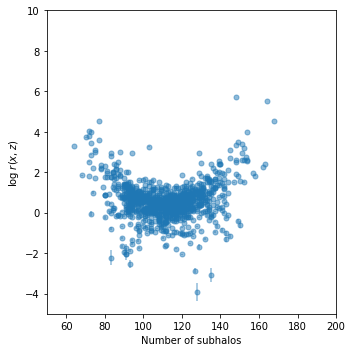

In [11]:
plt.figure(figsize=(5,5))

plt.errorbar(n_subs, log_r_xz, yerr=1.*log_r_xz_uncertainties, ls=" ", marker="o", ms=5., alpha=0.5)

plt.xlim(50,200)
plt.ylim(-5.,10.)
plt.xlabel("Number of subhalos")
plt.ylabel(r"$\log \; r(x,z)$")

plt.tight_layout()
plt.show()